In [1]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)
import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers
from sklearn.cluster import KMeans
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
import math

In [2]:
model_name = "alexnet"
target_layer = "classifier.2"
pooling = "ran"
path2data = f"{paths['results_path']}/imagenet_val_{model_name}_{target_layer}_{pooling}_features.pkl"

In [3]:
data = joblib.load(path2data)

In [4]:
variances = np.var(data, axis=0)
data_nonconst = data[:, variances != 0]
b = np.corrcoef(data_nonconst.T)


In [5]:
a = data_nonconst.T @ data_nonconst / data_nonconst.shape[1]

In [6]:
b = np.corrcoef(data_nonconst.T)

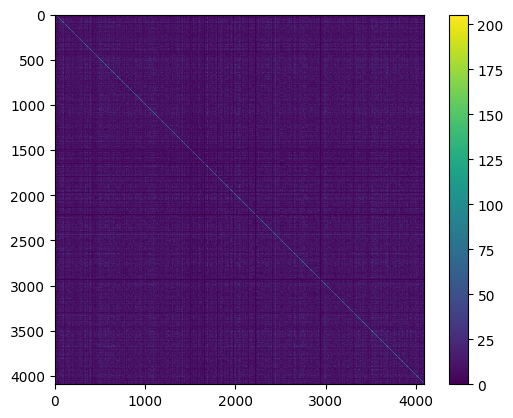

In [64]:
plt.imshow(a, cmap='viridis', interpolation='nearest')
plt.colorbar()

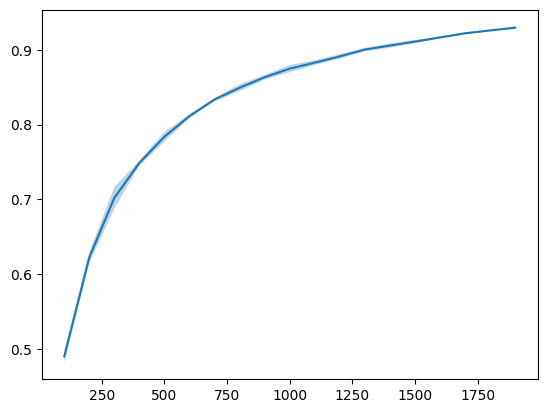

In [32]:
# do random subsampling (repeated many times) and see when this happens to converge
start, stop, step = 100, 2000, 100
num_reps = 10
correlations = []
sem = []
RDM = np.cov(data_nonconst.T)
RDM_idx = np.tril_indices(RDM.shape[0], k=-1)
flat_RDM = RDM[RDM_idx]
for N in range(start, stop, step): # TODO do it with cov instead of np.corrcoefs bc we're getting nans
    curr_corr = []
    for rep in range(num_reps):
        random_samples = np.random.choice(data_nonconst.shape[0], N, replace=False)
        new_data = data_nonconst[random_samples,:]
        new_RDM = np.cov(new_data.T)
        new_RDM_idx = np.tril_indices(new_RDM.shape[0], k=-1)
        flat_new_RDM = new_RDM[new_RDM_idx]
        r = np.corrcoef(flat_RDM, flat_new_RDM)[0,1]
        curr_corr.append(r)
    # for rep in range(num_reps):
    avg_r = np.mean(np.stack(curr_corr))
    sem_r = np.std(np.stack(curr_corr))
    correlations.append(avg_r)
    sem.append(sem_r)
# end for N in range(start, stop, step):
plt.plot(range(start, stop, step), correlations)
plt.fill_between(range(start, stop, step), np.stack(correlations) - np.stack(sem), np.stack(correlations) + np.stack(sem), alpha=0.3, label='Error range')

size curr_data (49152, 50)
size new_data (100, 50)
size new_data (100, 50)
size new_data (100, 50)
size new_data (100, 50)
size new_data (100, 50)
size new_data (600, 50)
size new_data (600, 50)
size new_data (600, 50)
size new_data (600, 50)
size new_data (600, 50)
size new_data (1100, 50)
size new_data (1100, 50)
size new_data (1100, 50)
size new_data (1100, 50)
size new_data (1100, 50)
size new_data (1600, 50)
size new_data (1600, 50)
size new_data (1600, 50)
size new_data (1600, 50)
size new_data (1600, 50)
size new_data (2100, 50)
size new_data (2100, 50)
size new_data (2100, 50)
size new_data (2100, 50)
size new_data (2100, 50)
size new_data (2600, 50)
size new_data (2600, 50)
size new_data (2600, 50)
size new_data (2600, 50)
size new_data (2600, 50)
size new_data (3100, 50)
size new_data (3100, 50)
size new_data (3100, 50)
size new_data (3100, 50)
size new_data (3100, 50)
size new_data (3600, 50)
size new_data (3600, 50)
size new_data (3600, 50)
size new_data (3600, 50)
size new

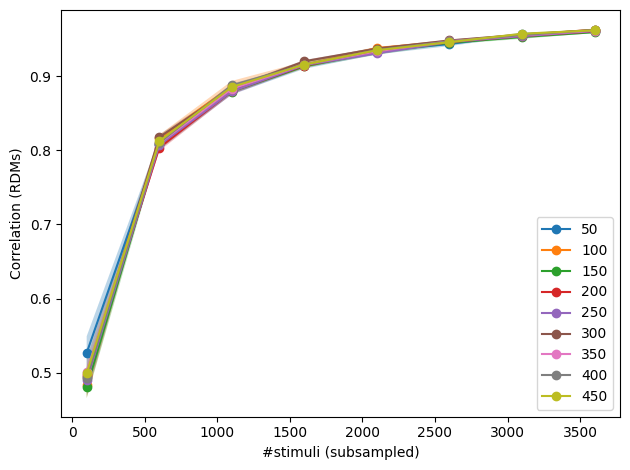

In [21]:
# do random subsampling (repeated many times) and see when this happens to converge
start, stop, step = 100, 4000, 500
startn, stopn, stepn = 50, 500, 50
num_reps = 5

for rand_neu_N in range(startn, stopn, stepn):
    correlations = []
    sem = []
    random_neu = np.random.choice(data_nonconst.shape[1], rand_neu_N, replace=False)    
    curr_data = data_nonconst[:,random_neu]
    print("size curr_data", curr_data.shape)
    curr_RDM = np.cov(curr_data.T)
    curr_RDM_idx = np.tril_indices(curr_RDM.shape[0], k=-1)
    curr_flat_RDM = curr_RDM[curr_RDM_idx]
    for N in range(start, stop, step): 
        curr_corr = []
        for rep in range(num_reps):
            random_samples = np.random.choice(data_nonconst.shape[0], N, replace=False)
            new_data = curr_data[random_samples,:]
            print("size new_data", new_data.shape)
            new_RDM = np.cov(new_data.T)
            new_RDM_idx = np.tril_indices(new_RDM.shape[0], k=-1)
            flat_new_RDM = new_RDM[new_RDM_idx]
            r = np.corrcoef(curr_flat_RDM, flat_new_RDM)[0,1]
            curr_corr.append(r)
        # for rep in range(num_reps):
        avg_r = np.mean(np.stack(curr_corr))
        sem_r = np.std(np.stack(curr_corr))
        correlations.append(avg_r)
        sem.append(sem_r)
    # end for N in range(start, stop, step):
    plt.plot(range(start, stop, step), correlations, marker='o')
    plt.legend(f"rand_neu_N = {rand_neu_N}")
    plt.fill_between(range(start, stop, step), np.stack(correlations) - np.stack(sem), np.stack(correlations) + np.stack(sem), alpha=0.3, label="_nolegend_")
# for rand_neu in range(startn, stopn, stepn):
plt.xlabel("#stimuli (subsampled)")
plt.ylabel("Correlation (RDMs)")
plt.legend(range(startn, stopn, stepn))
plt.tight_layout()
plt.show()